# Max-Cut and Traveling Salesman Problem

## Introduction

Optimization (or combinatorial optimization) means searching for an optimal solution in a finite or countably infinite set of potential solutions. Optimality is defined with respect to some criterion function, which is to be minimized or maximized. This is typically called cost function or objective function


#### Typical Optimizaion Problem 

Minimization: cost, distance, length of a traversal, weight, processing time, material, energy consumption, number of objects

Maximization: profit, value, output, return, yield, utility, efficiency, capacity, number of objects

## Weighted Max-Cut
Max-Cut is an NP-complete problem, with applications in clustering, network science, and statistical physics. To grasp how practical applications are mapped into given Max-Cut instances, consider a system of many people that can interact and influence each other. Individuals can be represented by vertices of a graph, and their interactions seen as pairwise connections between vertices of the graph, or edges. With this representation in mind, it is easy to model typical marketing problems.

suppose that it is assumed that individuals will influence each other’s buying decisions, and knowledge is given about how strong they will influence each other. The influence can be modeled by weights assigned on each edge of the graph. It is possible then to predict the outcome of a marketing strategy in which products are offered for free to some individuals, and then ask which is the optimal subset of individuals that should get the free products, in order to maximize revenues.


## Formal Definition

Consider an n-node undirected graph $G = (V, E)$ where $|V| = n$ with edge weights $w_{ij}>0$, $w_{ij}=w_{ji}$, for $(i,j)∈E$. A cut is defined as a partition of the original set $V$ into two subsets. The cost function to be optimized is in this case the sum of weights of edges connecting points in the two different subsets, crossing the cut. By assigning $x_i=0$ or $x_i=1$ to each node $i$, one tries to maximize the global profit function (here and in the following summations run over indices $0,1,…n-1)$


$$\tilde{C}(x)=\sum_{i,j}w_{ij}x_{i}(1−x_{j})$$



In [1]:
# basic python libraries
import matplotlib.pyplot as plt
import matplotlib.axes as axes
%matplotlib inline
import numpy as np
import networkx as nx

In [5]:
# importing the quantum computing libraries
from qiskit import Aer
from qiskit.tools.visualization import plot_histogram
from qiskit.circuit.library import TwoLocal
from qiskit.optimization.applications.ising import max_cut, tsp
from qiskit.aqua.algorithms import VQE, NumPyMinimumEigensolver
from qiskit.aqua.components.optimizers import SPSA
from qiskit.aqua import aqua_globals
from qiskit.aqua import QuantumInstance
from qiskit.optimization.applications.ising.common import sample_most_likely
from qiskit.optimization.algorithms import MinimumEigenOptimizer
from qiskit.optimization.problems import QuadraticProgram

In [6]:
# setup aqua logging
import logging
from qiskit.aqua import set_qiskit_aqua_logging

# Max-Cut Problem

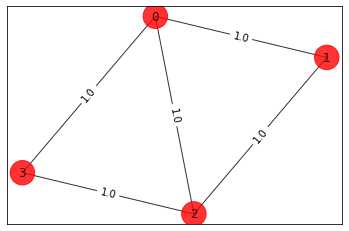

In [7]:
# Generating a graph of 4 nodes

n=4 # Number of nodes in graph
G=nx.Graph()
G.add_nodes_from(np.arange(0,n,1))
elist=[(0,1,1.0),(0,2,1.0),(0,3,1.0),(1,2,1.0),(2,3,1.0)]
# tuple is (i,j,weight) where (i,j) is the edge
G.add_weighted_edges_from(elist)

colors = ['r' for node in G.nodes()]
pos = nx.spring_layout(G)

def draw_graph(G, colors, pos):
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=.8, ax=default_axes, pos=pos)
    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)

draw_graph(G, colors, pos)

In [8]:
# Computing the weight matrix from the random graph
w = np.zeros([n,n])
for i in range(n):
    for j in range(n):
        temp = G.get_edge_data(i,j,default=0)
        if temp != 0:
            w[i,j] = temp['weight']
print(w)

[[0. 1. 1. 1.]
 [1. 0. 1. 0.]
 [1. 1. 0. 1.]
 [1. 0. 1. 0.]]


# Brute Force Approach
Try all possible $2^n$ combinations. For $n=4$, as in this example, one deals with only 16 combinations, but for $n = 1000$, one has $1.071509e+30$ combinations, which is impractical to deal with by using a brute force approach.



case = [0, 0, 0, 0] cost = 0.0
case = [1, 0, 0, 0] cost = 3.0
case = [0, 1, 0, 0] cost = 2.0
case = [1, 1, 0, 0] cost = 3.0
case = [0, 0, 1, 0] cost = 3.0
case = [1, 0, 1, 0] cost = 4.0
case = [0, 1, 1, 0] cost = 3.0
case = [1, 1, 1, 0] cost = 2.0
case = [0, 0, 0, 1] cost = 2.0
case = [1, 0, 0, 1] cost = 3.0
case = [0, 1, 0, 1] cost = 4.0
case = [1, 1, 0, 1] cost = 3.0
case = [0, 0, 1, 1] cost = 3.0
case = [1, 0, 1, 1] cost = 2.0
case = [0, 1, 1, 1] cost = 3.0
case = [1, 1, 1, 1] cost = 0.0

Best solution = [1, 0, 1, 0] cost = 4.0


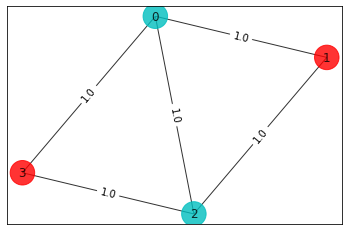

In [9]:
best_cost_brute = 0
for b in range(2**n):
    x = [int(t) for t in reversed(list(bin(b)[2:].zfill(n)))]
    cost = 0
    for i in range(n):
        for j in range(n):
            cost = cost + w[i,j]*x[i]*(1-x[j])
    if best_cost_brute < cost:
        best_cost_brute = cost
        xbest_brute = x
    print('case = ' + str(x)+ ' cost = ' + str(cost))

colors = ['r' if xbest_brute[i] == 0 else 'c' for i in range(n)]
draw_graph(G, colors, pos)
print('\nBest solution = ' + str(xbest_brute) + ' cost = ' + str(best_cost_brute))

# Mapping to the Ising Problem

Directly Generate the Ising Hamiltonian using QuadraticProgram

In [10]:
qubitOp, offset = max_cut.get_operator(w)
print('Offset:', offset)
print('Ising Hamiltonian:')
print(qubitOp.print_details())

Offset: -2.5
Ising Hamiltonian:
IIZZ	(0.5+0j)
IZIZ	(0.5+0j)
IZZI	(0.5+0j)
ZIIZ	(0.5+0j)
ZZII	(0.5+0j)



/usr/local/lib/python3.7/dist-packages/qiskit/optimization/applications/ising/max_cut.py:54: DeprecationWarning: The package qiskit.aqua.operators is deprecated. It was moved/refactored to qiskit.opflow (pip install qiskit-terra). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/master/README.md#migration-guide>
  return WeightedPauliOperator(paulis=pauli_list), shift


In [11]:
# mapping Ising Hamiltonian to Quadratic Program
qp = QuadraticProgram()
qp.from_ising(qubitOp, offset)
qp.to_docplex().prettyprint()

// This file has been generated by DOcplex
// model name is: AnonymousModel
// single vars section
dvar bool x_0;
dvar bool x_1;
dvar bool x_2;
dvar bool x_3;

minimize
 [ - 3 x_0^2 + 2 x_0*x_1 + 2 x_0*x_2 + 2 x_0*x_3 - 2 x_1^2 + 2 x_1*x_2
 - 3 x_2^2 + 2 x_2*x_3 - 2 x_3^2 ];
 
subject to {

}


In [12]:
# solving Quadratic Program using exact classical eigensolver
exact = MinimumEigenOptimizer(NumPyMinimumEigensolver())
result = exact.solve(qp)
print(result)

optimal function value: -4.0
optimal value: [1. 0. 1. 0.]
status: SUCCESS


/usr/local/lib/python3.7/dist-packages/qiskit/aqua/algorithms/minimum_eigen_solvers/minimum_eigen_solver.py:38: DeprecationWarning: The package qiskit.aqua.algorithms.minimum_eigen_solvers is deprecated. It was moved/refactored to qiskit.algorithms.minimum_eigen_solvers (pip install qiskit-terra). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/master/README.md#migration-guide>
  'qiskit-terra')
/usr/local/lib/python3.7/dist-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:38: DeprecationWarning: The package qiskit.aqua.algorithms.eigen_solvers is deprecated. It was moved/refactored to qiskit.algorithms.eigen_solvers (pip install qiskit-terra). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/master/README.md#migration-guide>
  'qiskit-terra')


Since the problem was cast to a minimization problem, the solution of −4 corresponds to the optimum

# Checking the Full Hamiltonian gives the right cost



/usr/local/lib/python3.7/dist-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:215: DeprecationWarning: The variable qiskit.aqua.aqua_globals is deprecated. It was moved/refactored to qiskit.utils.algorithm_globals (pip install qiskit-terra). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/master/README.md#migration-guide>
  unique, counts = np.unique(aqua_globals.random.choice(list(deterministic_counts.keys()),


energy: -1.5
max-cut objective: -4.0
solution: [0 1 0 1]
solution objective: 4.0


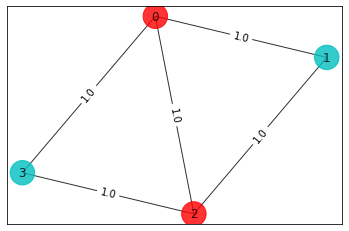

In [13]:
#Making the Hamiltonian in its full form and getting the lowest eigenvalue and eigenvector
ee = NumPyMinimumEigensolver(qubitOp)
result = ee.run()

x = sample_most_likely(result.eigenstate)
print('energy:', result.eigenvalue.real)
print('max-cut objective:', result.eigenvalue.real + offset)
print('solution:', max_cut.get_graph_solution(x))
print('solution objective:', max_cut.max_cut_value(x, w))

colors = ['r' if max_cut.get_graph_solution(x)[i] == 0 else 'c' for i in range(n)]
draw_graph(G, colors, pos)

# Running it on Quantum Computer

We run the optimization routine using a feedback loop with a quantum computer that uses trial functions built with $Y$ single-qubit rotations, 
$$U_{single}(θ)=∏^{n}_{i=1}Y(θ_i)$$
, and entangler steps $U_{entangler}$.


In [14]:
aqua_globals.random_seed = np.random.default_rng(123)
seed = 10598
backend = Aer.get_backend('statevector_simulator')
quantum_instance = QuantumInstance(backend, seed_simulator=seed, seed_transpiler=seed)

/usr/local/lib/python3.7/dist-packages/qiskit/aqua/quantum_instance.py:137: DeprecationWarning: The class qiskit.aqua.QuantumInstance is deprecated. It was moved/refactored to qiskit.utils.QuantumInstance (pip install qiskit-terra). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/master/README.md#migration-guide>
  'qiskit-terra')


/usr/local/lib/python3.7/dist-packages/qiskit/aqua/components/optimizers/optimizer.py:50: DeprecationWarning: The package qiskit.aqua.components.optimizers is deprecated. It was moved/refactored to qiskit.algorithms.optimizers (pip install qiskit-terra). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/master/README.md#migration-guide>
  'qiskit.algorithms.optimizers', 'qiskit-terra')
/usr/local/lib/python3.7/dist-packages/qiskit/aqua/algorithms/vq_algorithm.py:72: DeprecationWarning: The class qiskit.aqua.algorithms.VQAlgorithm is deprecated. It was moved/refactored to qiskit.algorithms.VariationalAlgorithm (pip install qiskit-terra). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/master/README.md#migration-guide>
  'qiskit-terra')


energy: -1.4999796718931653
time: 6.112574577331543
max-cut objective: -3.9999796718931653
solution: [1. 0. 1. 0.]
solution objective: 4.0


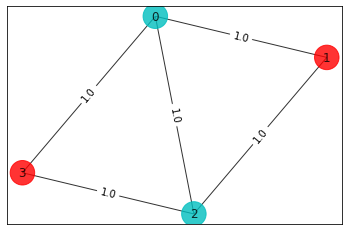

In [15]:
# construct VQE
spsa = SPSA(maxiter=300)
ry = TwoLocal(qubitOp.num_qubits, 'ry', 'cz', reps=5, entanglement='linear')
vqe = VQE(qubitOp, ry, spsa, quantum_instance=quantum_instance)

# run VQE
result = vqe.run(quantum_instance)

# print results
x = sample_most_likely(result.eigenstate)
print('energy:', result.eigenvalue.real)
print('time:', result.optimizer_time)
print('max-cut objective:', result.eigenvalue.real + offset)
print('solution:', max_cut.get_graph_solution(x))
print('solution objective:', max_cut.max_cut_value(x, w))

# plot results
colors = ['r' if max_cut.get_graph_solution(x)[i] == 0 else 'c' for i in range(n)]
draw_graph(G, colors, pos)

optimal function value: -4.0
optimal value: [1. 0. 1. 0.]
status: SUCCESS


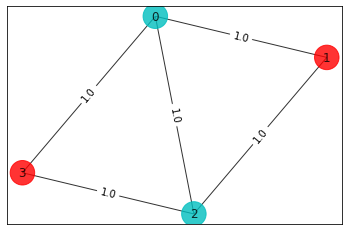

In [16]:
# create minimum eigen optimizer based on VQE
vqe_optimizer = MinimumEigenOptimizer(vqe)

# solve quadratic program
result = vqe_optimizer.solve(qp)
print(result)

colors = ['r' if result.x[i] == 0 else 'c' for i in range(n)]
draw_graph(G, colors, pos)

## Travelling Salesman Problem

In addition to being a notorious NP-complete problem that has drawn the attention of computer scientists and mathematicians for over two centuries, the Traveling Salesman Problem (TSP) has important bearings on finance and marketing, as its name suggests. Colloquially speaking, the traveling salesman is a person that goes from city to city to sell merchandise. The objective in this case is to find the shortest path that would enable the salesman to visit all the cities and return to its hometown, i.e. the city where he started traveling. By doing this, the salesman gets to maximize potential sales in the least amount of time


The problem derives its importance from its “hardness” and ubiquitous equivalence to other relevant combinatorial optimization problems that arise in practice.

The mathematical formulation with some early analysis was proposed by W.R. Hamilton in the early 19th century. Mathematically the problem is, as in the case of Max-Cut, best abstracted in terms of graphs. The TSP on the nodes of a graph asks for the shortest Hamiltonian cycle that can be taken through each of the nodes. A Hamilton cycle is a closed path that uses every vertex of a graph once. The general solution is unknown and an algorithm that finds it efficiently (e.g., in polynomial time) is not expected to exist.


## Approach

Find the shortest Hamiltonian cycle in a graph $G=(V,E)$ with $n=|V|$ nodes and distances, $w_{ij}$ (distance from vertex i to vertex j). A Hamiltonian cycle is described by $N^2$ variables $x_{i,p}$, where $i$ represents the node and $p$ represents its order in a prospective cycle. The decision variable takes the value 1 if the solution occurs at node $i$ at time order $p$. We require that every node can only appear once in the cycle, and for each time a node has to occur. This amounts to the two constraints (here and in the following, whenever not specified, the summands run over $0,1,…N-1)$

$$∑_{i}x_{i,p} =1  ∀ p$$
$$∑_{p}x_{i,p} =1  ∀i$$.

For nodes in our prospective ordering, if $x_{i,p}$ and $x_{j,p+1}$ are both 1, then there should be an energy penalty if $(i,j)∉E$ (not connected in the graph). The form of this penalty is

$$∑_{i,j∉E}∑_{p}x_{i,p}x_{j,p+1}>0,$$


where it is assumed the boundary condition of the Hamiltonian cycles $(p=N)≡(p=0)$. However, here it will be assumed a fully connected graph and not include this term. The distance that needs to be minimized is

$$C(x)=∑_{i,j}w_{ij}∑_{p}x_{i,p}x_{j,p+1}$$

Putting this all together in a single objective function to be minimized, we get the following:



$$C(x)=∑_{i,j}w_{ij}∑_{p}x_{i,p}x_{j,p+1}+A ∑_{p}(1−∑_{i}x_{i,p})^2+A ∑_{i}(1−∑_{p}x_{i,p})^2,$$

where A is a free parameter. One needs to ensure that A is large enough so that these constraints are respected. One way to do this is to choose A such that $A>max(w_{ij})$.

Once again, it is easy to map the problem in this form to a quantum computer, and the solution will be found by minimizing a Ising Hamiltonian.


distance
 [[ 0. 48. 91.]
 [48.  0. 63.]
 [91. 63.  0.]]


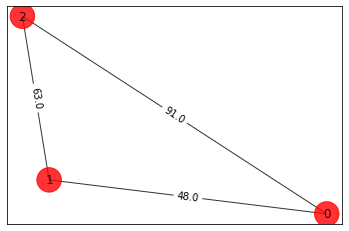

In [17]:
# Generating a graph of 3 nodes
n = 3
num_qubits = n ** 2
ins = tsp.random_tsp(n, seed=123)
print('distance\n', ins.w)

# Draw the graph
G = nx.Graph()
G.add_nodes_from(np.arange(0, ins.dim, 1))
colors = ['r' for node in G.nodes()]

for i in range(0, ins.dim):
    for j in range(i+1, ins.dim):
        G.add_edge(i, j, weight=ins.w[i,j])

pos = {k: v for k, v in enumerate(ins.coord)}

draw_graph(G, colors, pos)

## Brute Force Approach

order = (0, 1, 2) Distance = 202.0
Best order from brute force = (0, 1, 2) with total distance = 202.0


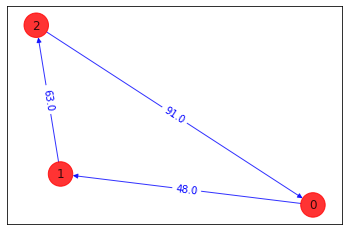

In [18]:
from itertools import permutations

def brute_force_tsp(w, N):
    a=list(permutations(range(1,N)))
    last_best_distance = 1e10
    for i in a:
        distance = 0
        pre_j = 0
        for j in i:
            distance = distance + w[j,pre_j]
            pre_j = j
        distance = distance + w[pre_j,0]
        order = (0,) + i
        if distance < last_best_distance:
            best_order = order
            last_best_distance = distance
            print('order = ' + str(order) + ' Distance = ' + str(distance))
    return last_best_distance, best_order

best_distance, best_order = brute_force_tsp(ins.w, ins.dim)
print('Best order from brute force = ' + str(best_order) + ' with total distance = ' + str(best_distance))

def draw_tsp_solution(G, order, colors, pos):
    G2 = nx.DiGraph()
    G2.add_nodes_from(G)
    n = len(order)
    for i in range(n):
        j = (i + 1) % n
        G2.add_edge(order[i], order[j], weight=G[order[i]][order[j]]['weight'])
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G2, node_color=colors, edge_color='b', node_size=600, alpha=.8, ax=default_axes, pos=pos)
    edge_labels = nx.get_edge_attributes(G2, 'weight')
    nx.draw_networkx_edge_labels(G2, pos, font_color='b', edge_labels=edge_labels)

draw_tsp_solution(G, best_order, colors, pos)

## Mapping to the Ising Problem

In [19]:
qubitOp, offset = tsp.get_operator(ins)
print('Offset:', offset)
print('Ising Hamiltonian:')
print(qubitOp.print_details())

Offset: 600303.0
Ising Hamiltonian:
IIIIIIIIZ	(-100069.5+0j)
IIIIZIIII	(-100055.5+0j)
IIIIZIIIZ	(12+0j)
IIIIIIIZI	(-100069.5+0j)
IIIZIIIII	(-100055.5+0j)
IIIZIIIZI	(12+0j)
IIIIIIZII	(-100069.5+0j)
IIIIIZIII	(-100055.5+0j)
IIIIIZZII	(12+0j)
IZIIIIIII	(-100077+0j)
IZIIIIIIZ	(22.75+0j)
ZIIIIIIII	(-100077+0j)
ZIIIIIIZI	(22.75+0j)
IIZIIIIII	(-100077+0j)
IIZIIIZII	(22.75+0j)
IIIIIZIZI	(12+0j)
IIIIZIZII	(12+0j)
IIIZIIIIZ	(12+0j)
IZIIIZIII	(15.75+0j)
ZIIIZIIII	(15.75+0j)
IIZZIIIII	(15.75+0j)
IIZIIIIZI	(22.75+0j)
IZIIIIZII	(22.75+0j)
ZIIIIIIIZ	(22.75+0j)
IIZIZIIII	(15.75+0j)
IZIZIIIII	(15.75+0j)
ZIIIIZIII	(15.75+0j)
IIIIIZIIZ	(50000+0j)
IIZIIIIIZ	(50000+0j)
IIZIIZIII	(50000+0j)
IIIIZIIZI	(50000+0j)
IZIIIIIZI	(50000+0j)
IZIIZIIII	(50000+0j)
IIIZIIZII	(50000+0j)
ZIIIIIZII	(50000+0j)
ZIIZIIIII	(50000+0j)
IIIIIIIZZ	(50000+0j)
IIIIIIZIZ	(50000+0j)
IIIIIIZZI	(50000+0j)
IIIIZZIII	(50000+0j)
IIIZIZIII	(50000+0j)
IIIZZIIII	(50000+0j)
IZZIIIIII	(50000+0j)
ZIZIIIIII	(50000+0j)
ZZIIIIIII	(50000+0j)



In [20]:
qp = QuadraticProgram()
qp.from_ising(qubitOp, offset, linear=True)
qp.to_docplex().prettyprint()

// This file has been generated by DOcplex
// model name is: AnonymousModel
// single vars section
dvar bool x_0;
dvar bool x_1;
dvar bool x_2;
dvar bool x_3;
dvar bool x_4;
dvar bool x_5;
dvar bool x_6;
dvar bool x_7;
dvar bool x_8;

minimize
 - 200000 x_0 - 200000 x_1 - 200000 x_2 - 200000 x_3 - 200000 x_4 - 200000 x_5
 - 200000 x_6 - 200000 x_7 - 200000 x_8 [ 200000 x_0*x_1 + 200000 x_0*x_2
 + 200000 x_0*x_3 + 48 x_0*x_4 + 48 x_0*x_5 + 200000 x_0*x_6 + 91 x_0*x_7
 + 91 x_0*x_8 + 200000 x_1*x_2 + 48 x_1*x_3 + 200000 x_1*x_4 + 48 x_1*x_5
 + 91 x_1*x_6 + 200000 x_1*x_7 + 91 x_1*x_8 + 48 x_2*x_3 + 48 x_2*x_4
 + 200000 x_2*x_5 + 91 x_2*x_6 + 91 x_2*x_7 + 200000 x_2*x_8 + 200000 x_3*x_4
 + 200000 x_3*x_5 + 200000 x_3*x_6 + 63 x_3*x_7 + 63 x_3*x_8 + 200000 x_4*x_5
 + 63 x_4*x_6 + 200000 x_4*x_7 + 63 x_4*x_8 + 63 x_5*x_6 + 63 x_5*x_7
 + 200000 x_5*x_8 + 200000 x_6*x_7 + 200000 x_6*x_8 + 200000 x_7*x_8 ] +
 600000;
 
subject to {

}


In [21]:
result = exact.solve(qp)
print(result)

optimal function value: 202.0
optimal value: [1. 0. 0. 0. 1. 0. 0. 0. 1.]
status: SUCCESS


## Checking that the Full Hamiltonian gives the Right Cost

energy: -600101.0
tsp objective: 202.0
feasible: True
solution: [0, 1, 2]
solution objective: 202.0


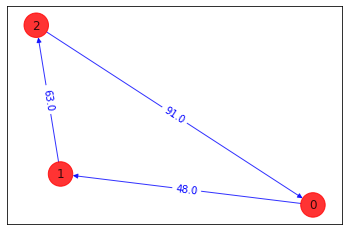

In [22]:
#Making the Hamiltonian in its full form and getting the lowest eigenvalue and eigenvector
ee = NumPyMinimumEigensolver(qubitOp)
result = ee.run()

print('energy:', result.eigenvalue.real)
print('tsp objective:', result.eigenvalue.real + offset)
x = sample_most_likely(result.eigenstate)
print('feasible:', tsp.tsp_feasible(x))
z = tsp.get_tsp_solution(x)
print('solution:', z)
print('solution objective:', tsp.tsp_value(z, ins.w))
draw_tsp_solution(G, z, colors, pos)

## Running it on Quantum Computer

We run the optimization routine using a feedback loop with a quantum computer that uses trial functions built with $Y$ single-qubit rotations, 
$$ U_{single}(θ)= ∏^{n}_{i=1} Y(θ_i)$$, and entangler steps $U_{entangler}$.

In [23]:
aqua_globals.random_seed = np.random.default_rng(123)
seed = 10598
backend = Aer.get_backend('statevector_simulator')
quantum_instance = QuantumInstance(backend, seed_simulator=seed, seed_transpiler=seed)

energy: -587129.7995590195
time: 14.691826581954956
feasible: True
solution: [1, 2, 0]
solution objective: 202.0


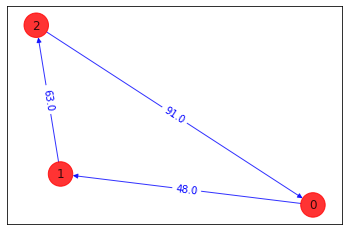

In [24]:
spsa = SPSA(maxiter=300)
ry = TwoLocal(qubitOp.num_qubits, 'ry', 'cz', reps=5, entanglement='linear')
vqe = VQE(qubitOp, ry, spsa, quantum_instance=quantum_instance)

result = vqe.run(quantum_instance)

print('energy:', result.eigenvalue.real)
print('time:', result.optimizer_time)
x = sample_most_likely(result.eigenstate)
print('feasible:', tsp.tsp_feasible(x))
z = tsp.get_tsp_solution(x)
print('solution:', z)
print('solution objective:', tsp.tsp_value(z, ins.w))
draw_tsp_solution(G, z, colors, pos)

In [25]:
aqua_globals.random_seed = np.random.default_rng(123)
seed = 10598
backend = Aer.get_backend('statevector_simulator')
quantum_instance = QuantumInstance(backend, seed_simulator=seed, seed_transpiler=seed)

/usr/local/lib/python3.7/dist-packages/qiskit/optimization/algorithms/optimization_algorithm.py:136: UserWarning: The sum of probability of samples is not close to 1: 0.9999899678400582
  warn('The sum of probability of samples is not close to 1: {}'.format(sum_prob))


optimal function value: 202.0
optimal value: [0. 0. 1. 0. 1. 0. 1. 0. 0.]
status: SUCCESS
solution: [1, 2, 0]
solution objective: 202.0


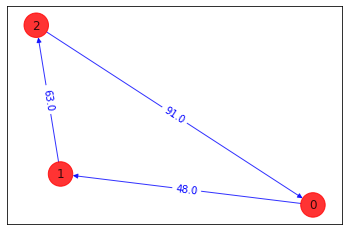

In [26]:
# create minimum eigen optimizer based on VQE
vqe_optimizer = MinimumEigenOptimizer(vqe)

# solve quadratic program
result = vqe_optimizer.solve(qp)
print(result)

z = tsp.get_tsp_solution(x)
print('solution:', z)
print('solution objective:', tsp.tsp_value(z, ins.w))
draw_tsp_solution(G, z, colors, pos)